In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [45]:
base_dir = r"D:\Uni work\Engineering Mathematics Work\Data Science\Snap Vision"
direct = r"D:\Uni work\Engineering Mathematics Work\Data Science\Snap Vision\uob_image_set\11059585"
images_dir = os.path.join(base_dir, "uob_image_set")
file_num = "11059585"

test_dir = os.path.join(images_dir, file_num )
train_image = os.path.join(test_dir, file_num + "_0.jpg")
test_image = os.path.join(test_dir, file_num + "_1.jpg") 

# Reading an image in default mode 
src_train = cv2.imread(train_image)
src_test =  cv2.imread(test_image)

# Convert the training image to RGB
training_image = cv2.cvtColor(src_train, cv2.COLOR_BGR2RGB)
testing_image = cv2.cvtColor(src_test, cv2.COLOR_BGR2RGB)

# Convert the training and test image to gray scale
training_grey = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)
testing_grey = cv2.cvtColor(testing_image, cv2.COLOR_RGB2GRAY)


In [76]:
def find_and_draw_keypoints(grey_image, coloured_image):
    sift = cv2.SIFT_create()
    kp = sift.detect(grey_image,None)
    # produce keypoint descriptors (des)
    kp, des = sift.compute(grey_image,kp)
    img=cv2.drawKeypoints(grey_image,kp, coloured_image)
    return img, kp, des 

def show_image(image, window_name = "image"):
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [88]:
kp_train_grey, train_kp, train_des  = find_and_draw_keypoints(training_grey, training_image)
print(len(kp_train_grey))
show_image(kp_train_grey)
kp_test_grey, test_kp, test_des  = find_and_draw_keypoints(testing_grey, testing_image)
print(len(kp_test_grey))
show_image(kp_test_grey)

1334
1334


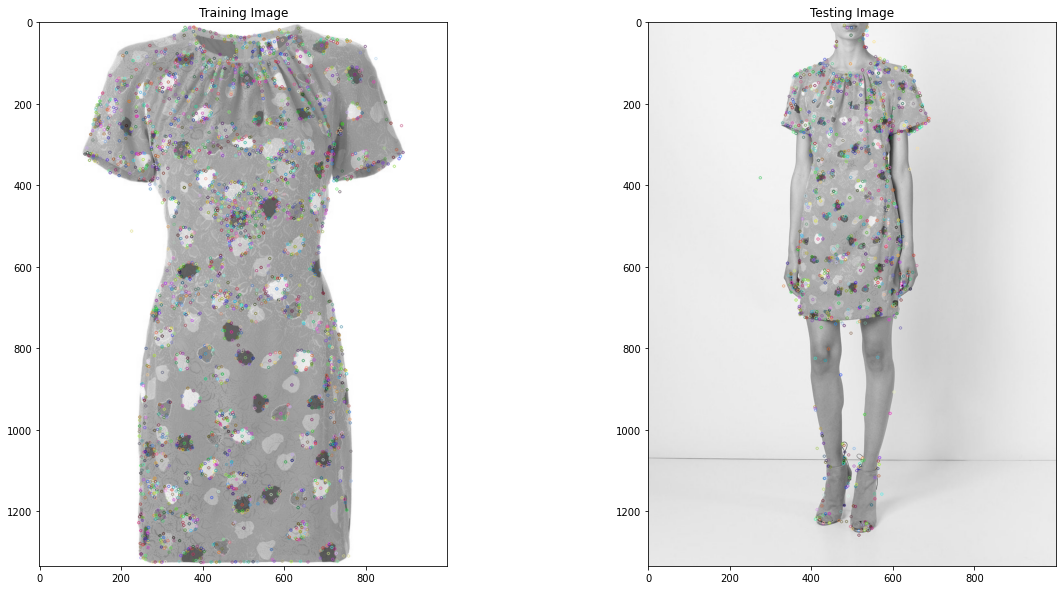

In [56]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(testing_image)

In [84]:
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 0


def match_features(img1,kp1,des1,img2,kp2,des2,):
    # kp1 - keypoints of image 1
    # des1 -description of image 1
    # image1 and image2 are just the two comparison images
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    print(len(good))
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    return img3

In [85]:

feature_img =match_features(training_grey,train_kp,train_des,testing_grey, test_kp,test_des)
show_image(feature_img)

59
